<a href="https://colab.research.google.com/github/eric-r-xu/DiscardWisdom/blob/main/DiscardWisdom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive

*** /content/drive/MyDrive/mahjong/examples/1.png ***



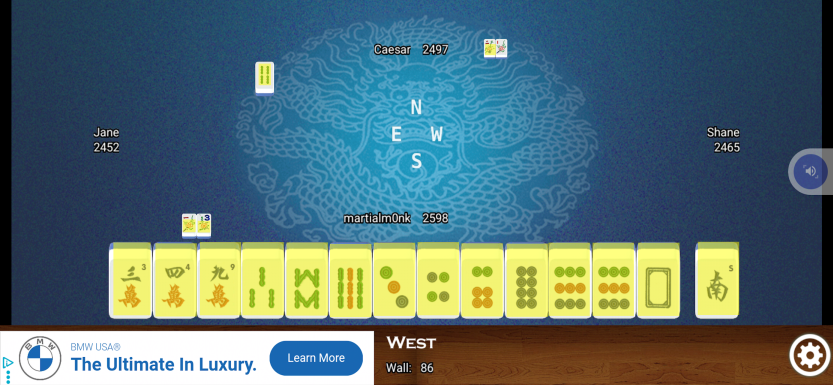


Recommended discard tiles ranked from most to least (higher score indicates higher recommendation):

swh: 54
wdh: 54
9d: 54
8b: 52
4c: 51
9c: 51
3b: 49
5b: 49
7c: 49
8d: 48
3d: 47
6d: 47
4d: 45

*** /content/drive/MyDrive/mahjong/examples/2.png ***



In [ ]:
import cv2
import sys
from collections import defaultdict
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/mahjong')

from image_utils import show_image, init_screenshot, find_and_mark_locations
from file_utils import load_template_files, initialize_all_tiles
from mahjong_checker import MahjongHandChecker

for i in range(1, 11):

    screenshot_path = f"/content/drive/MyDrive/mahjong/examples/{i}.png"
    template_dir = "/content/drive/MyDrive/mahjong/hkmj_tile_templates/"
    print(f'\n*** {screenshot_path} ***\n')
    template_files = load_template_files(template_dir)

    image, match_mask = init_screenshot(screenshot_path)
    overlay = image.copy()
    templates = {file: cv2.imread(file) for file in template_files}

    tiles_found = defaultdict(int)
    collective = defaultdict(int)
    player_you = defaultdict(int)
    player_left = defaultdict(int)
    player_right = defaultdict(int)
    player_across = defaultdict(int)
    player_you_discardable = defaultdict(int)

    for template_path, template_image in templates.items():
        _template_id = template_path.split("/")[-3:]
        _player, _type, _tile = (
            _template_id[0],
            _template_id[1],
            _template_id[2].replace(".png", ""),
        )
        if template_image is None:
            print(f"Error: Could not read the template image at {template_path}")
            continue
        found_tiles = find_and_mark_locations(template_image, image, overlay, match_mask)
        if found_tiles > 0:
            # print('..................................................')
            tiles_found[_tile] += found_tiles
            exec(f"{_player}['{_tile}'] += {found_tiles}")
            if _type == "discardable":
                player_you_discardable[_tile] += found_tiles

    highlight_image = cv2.addWeighted(overlay, 0.5, image, 0.5, 0)
    show_image(highlight_image, 0.3)

    all_tiles = initialize_all_tiles()

    for tile, num_tiles in collective.items():
        all_tiles[tile] -= num_tiles

    checker = MahjongHandChecker(player_you_discardable, player_you, all_tiles)

    discard_scores = checker.gen_discard_scores()
    print("\nRecommended discard tiles ranked from most to least (higher score indicates higher recommendation):\n")
    for tile, score in sorted(discard_scores.items(), key=lambda item: item[1], reverse=True):
        if player_you_discardable[tile] > 0:
            print(f"{tile}: {score}")